In [11]:
import pandas as pd
import numpy as np

df_with_python = pd.read_json("assistant_with_python.json")
df_without_python = pd.read_json("assistant_without_python.json")
df_o4_mini = pd.read_json("o4-mini-responses.json")


In [12]:
python_e_o = df_with_python.drop(['question', 'ai_response'], axis=1)
nopython_e_o = df_without_python.drop(['question', 'ai_response'], axis=1)
o4_mini_e_o = df_o4_mini.drop(["question", "ai_response"], axis=1)

In [13]:
print(python_e_o)
print(nopython_e_o)
print(o4_mini_e_o)

    expected_answer  actual_answer
0           1263.19    1263.190000
1         266670.41  266670.410000
2            708.91       3.140000
3             10.00      10.000000
4          10893.04   10893.043521
..              ...            ...
67        323492.92  323492.920000
68          1117.95    1117.950000
69             8.56       8.557000
70        180074.78  180075.000000
71         -2659.73   -3473.570000

[72 rows x 2 columns]
    expected_answer  actual_answer
0           1263.19        1260.09
1         266670.41      266629.00
2            708.91           3.14
3             10.00          10.10
4          10893.04        6267.60
..              ...            ...
67        323492.92      323330.00
68          1117.95        1116.08
69             8.56          10.50
70        180074.78      163971.00
71         -2659.73      -10321.80

[72 rows x 2 columns]
    expected_answer  actual_answer
0           1263.19        1263.07
1         266670.41      266712.00
2        

In [14]:
combined_df = pd.concat(
    [
        python_e_o.assign(model="gpt_4.1_with_python"),
        nopython_e_o.assign(model="gpt_4.1_without_python"),
        o4_mini_e_o.assign(model="o4_mini_without_python"),
    ],
    ignore_index=True,
)

In [15]:
combined_df['correct'] = (
    np.where(
        combined_df['expected_answer'] == 0,
        (combined_df['actual_answer'] == 0).astype(int),
        (abs(combined_df['expected_answer'] - combined_df['actual_answer']) <= 0.01 * abs(combined_df['expected_answer'])).astype(int)
    )
)

combined_df['percent_error'] = (
    (combined_df['actual_answer'] - combined_df['expected_answer']) / combined_df['expected_answer']
) * 100

In [16]:
combined_df.groupby('model').describe()

expected_answer                                        \
                                 count          mean            std      min   
model                                                                          
gpt_4.1_with_python               72.0  58304.137778  105480.628573 -2659.73   
gpt_4.1_without_python            72.0  58304.137778  105480.628573 -2659.73   
o4_mini_without_python            72.0  58304.137778  105480.628573 -2659.73   

                                                              actual_answer  \
                           25%       50%       75%        max         count   
model                                                                         
gpt_4.1_with_python     629.53  1748.175  31615.91  323492.92          72.0   
gpt_4.1_without_python  629.53  1748.175  31615.91  323492.92          72.0   
o4_mini_without_python  629.53  1748.175  31615.91  323492.92          72.0   

                                      ... correct      percent_error  \
                                mean  ...     75%  max         count   
model                                 ...                              
gpt_4.1_with_python     55613.690633  ...     1.0  1.0          72.0   
gpt_4.1_without_python  53937.585972  ...     1.0  1.0          72.0   
o4_mini_without_python  55568.092778  ...     1.0  1.0          72.0   

                                                                       \
                             mean         std          min        25%   
model                                                                   
gpt_4.1_with_python    -34.403691  159.698810 -1285.043305  -0.000367   
gpt_4.1_without_python -40.472327  122.221422  -657.612991 -24.648195   
o4_mini_without_python -18.267094   58.211711  -261.956770  -0.208411   

                                                        
                             50%       75%         max  
model                                                   
gpt_4.1_with_python     0.000000  0.000000   74.220239  
gpt_4.1_without_python -0.133678  0.400902  288.076985  
o4_mini_without_python -0.001893  0.035262   39.111865  

[3 rows x 32 columns]

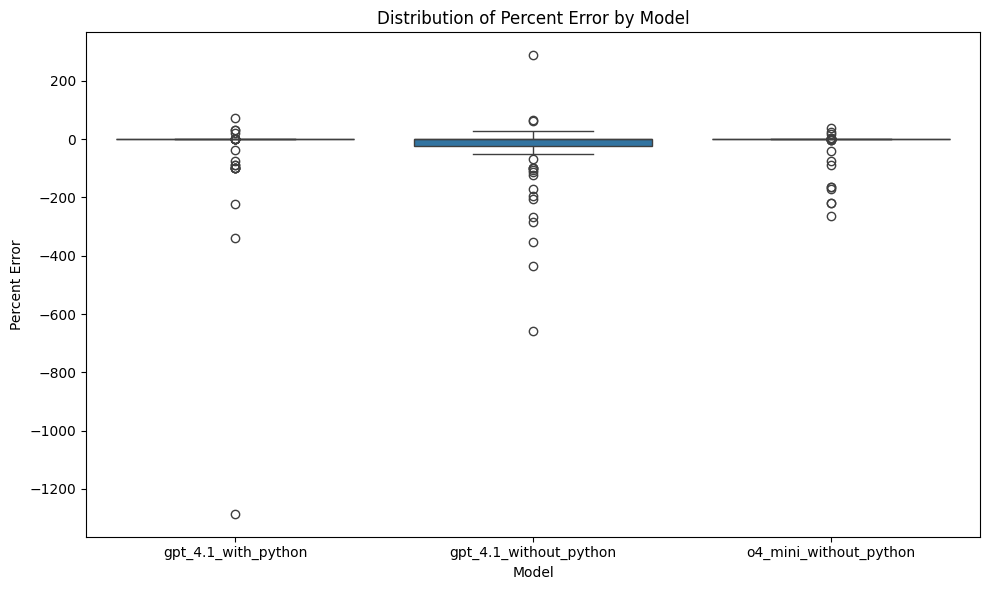

Interquartile Range (IQR) of percent_error by model:
 model
gpt_4.1_with_python        0.000367
gpt_4.1_without_python    25.049097
o4_mini_without_python     0.243673
Name: percent_error, dtype: float64

Standard Deviation (std) of percent_error by model:
 model
gpt_4.1_with_python       159.698810
gpt_4.1_without_python    122.221422
o4_mini_without_python     58.211711
Name: percent_error, dtype: float64


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='percent_error', data=combined_df)
plt.title('Distribution of Percent Error by Model')
plt.ylabel('Percent Error')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

iqr = combined_df.groupby('model')['percent_error'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
std = combined_df.groupby('model')['percent_error'].std()

print("Interquartile Range (IQR) of percent_error by model:\n", iqr)
print("\nStandard Deviation (std) of percent_error by model:\n", std)